# Solving systems of linear equations

## Contents
+ Detecting collisions in a 2D video game
+ Writing equations to represent lines and finding where lines intersect in the plane
+ Picturing and solving systems of linear equations in 3D or beyond
+ Re-writing vectors as linear combinations of other vectors

## Intro

This chapter deals with *systems of linear equations*. These problems boild down to finding points where lines, planes, or their higher dimensional analogies intersect.

To make things interesting, we'll develop an [Asteroids](https://en.wikipedia.org/wiki/Asteroids_(video_game)) bootleg in which we'll need to deal with these equations to figure out when the laser hits an asteroid.

Afterwards, we'll generalize the approach to higher dimensions.

## Designing the game

As we'll use the game as the *playground* to understand where equations are useful, we will simplify the approach and assume that the ship and asteroids are static for now.

### Modeling the game
To get started, we must model the entities of the game: the spaceship, the laser, and the asteroids. We also need to lay out the strategy to render them onscreen.

The spaceship and asteroids will be modeled as collections of vectors. For example, the following diagram is an 8-sided asteroid, defined by eight vectors.

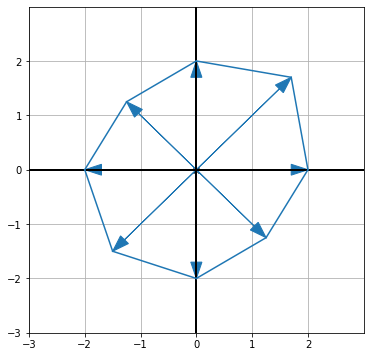

In [12]:
from my_draw2d import Arrow2D, Polygon2D, draw2d, blue

points = [(0, 2), (1.7, 1.7), (2, 0), (1.25, -1.25), (0, -2),
            (-1.5, -1.5), (-2, 0), (-1.25, 1.25)]

arrows = [Arrow2D(p, color=blue) for p in points]
polygon = Polygon2D(*points, color=blue)

draw2d(*arrows, polygon)

Both the asteroid and the spaceship will be subject of translations and rotations, which hints that apart from storing the eight vectors that define it, we need to keep track of its center, which will change over time, and the angle indicating the rotation of the object at any current moment.

As both the spaceship and the asteroids will share some *traits* it seems natural to pull these commonalities into a class that will define both:

In [ ]:
class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

Now we can start defining the ship as a subclass of `PolygonModel` as a triangle with fixed measurements:

In [13]:
class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

class Ship(PolygonModel):
    def __init__(self):
        super().__init__([(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)])

For the asteroid, we initialize it with a random number of points between 5 and 9, at equally spaced angles and random lengths between 0.5 and 1.0.as_integer_ratio.

In [15]:
from my_vectors import to_cartesian
from math import pi
from random import randint, uniform

class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

class Asteroid(PolygonModel):
    def __init__(self):
        sides = randint(5, 9)
        points = [to_cartesian((uniform(0.5, 1.0), 2 * pi * i / sides))
            for i in range(0, sides)
        ]
        super().__init__(points)

### Rendering the game

For the initial state of the game, we need a ship and several asteroids. We'll place the ship at the center of the screen, with the asteroids randomly spaced out over the screen. We'll show everything in the area of the plane ranging from -10 to 10 in the x and y directions.

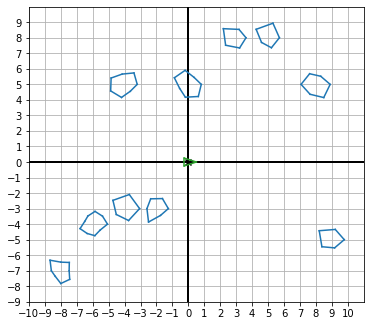

In [1]:
from my_game import Ship, Asteroid
from random import randint
from my_draw2d import Arrow2D, Polygon2D, draw2d, blue, green

asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

translated_asteroid_points = [
    [(x + asteroid.x, y + asteroid.y) for (x, y) in asteroid.points] for asteroid in asteroids
]

asteroids_as_polygons = [Polygon2D(*asteroid_points, color=blue) for asteroid_points in translated_asteroid_points]

ship = Ship()

draw2d(*asteroids_as_polygons, Polygon2D(*ship.points, color=green))

We can define a function in `PolygonModel` to represent this transformation:

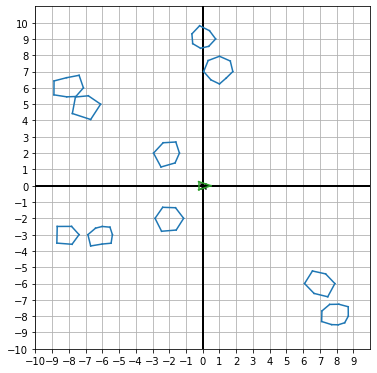

In [9]:
from my_vectors import add, to_cartesian
from my_game import Ship
from random import randint, uniform
from my_draw2d import Arrow2D, Polygon2D, draw2d, blue, green
from math import pi

class PolygonModel():
    def __init__(self, points):
        self.points = points
        self.rotation_angle = 0
        # x, y keeps track of the center of the polygon
        self.x = 0
        self.y = 0

    def transformed(self):
        return [add((self.x, self.y), v) for v in self.points]

class Asteroid(PolygonModel):
    def __init__(self):
        sides = randint(5, 9)
        points = [to_cartesian((uniform(0.5, 1.0), 2 * pi * i / sides))
            for i in range(0, sides)
        ]
        super().__init__(points)

asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

ship = Ship()

draw2d(*[Polygon2D(*asteroid.transformed()) for asteroid in asteroids], Polygon2D(*ship.points, color=green))

We will be using a 400x400 pixel screen, and the coordinate convention for computer displays, which is slightly different than the one used for math plots:

![Math to Computer displays](../images/math-to-computer-coordinates.png)

To facilitate the *translation* from the math axis coordinates to the ones used for computer games, we can write a `to_pixels()` function:

In [10]:
width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

# (0, 0) gets mapped to the center of the game window
print(to_pixels(0, 0)) 

# the right top corner gets mapped to the right top corner of the game window
print(to_pixels(10, 10))

# the right bottom corner gets mapped to the right bottom corner of the game window
print(to_pixels(10, -10))

# the left top corner gets mapped to the left top corner of the game window
print(to_pixels(-10, 10))

# the left bottom corner gets mapped to the left bottom corner of the game window
print(to_pixels(-10, -10))

(200.0, 200.0)
(400.0, 0.0)
(400.0, 400.0)
(0.0, 0.0)
(0.0, 400.0)


Now we can write the first step of the game, which just consists of the asteroids and ship being displayed using the `pygame` engine with no movement.

You can also find the runnable code in [Asteroids: first step](../e00-my-draw-lib+game-entities/asteroids_step1.py)

In [2]:
import pygame
from my_game import Ship, Asteroid
from random import randint
import sys

# Initialize game state
ship = Ship()
asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

# colors and settings

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points, 10)


def main():
    pygame.display.init()
    screen = pygame.display.set_mode([width, height])
    pygame.display.set_caption('Asteroids')

    done = False
    clock = pygame.time.Clock()

    while not done:
        clock.tick()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True

        screen.fill(BLACK)

        draw_poly(screen, ship)
        for asteroid in asteroids:
            draw_poly(screen, asteroid, color=GREEN)
        
        pygame.display.flip()

    pygame.display.quit()
    pygame.quit()
    sys.exit(0)

if __name__ == '__main__':
    main()

SystemExit: 0

### Shooting the laser

Now, we'll add the capability to let the user aim the ship using the left and right arrow keys, and then shoot a laser by pressing the spacebar.

As in the original Asteroids game, the laser beam should come out of the tip of the spaceship and extend to the edge of the screen.

In our 2D world model, the laser beam will be a segment starting at the transformed top of the spaceship, extending in whatever direction the ship is pointed. We will make sure it reaches the end of the screen by making it sufficiently long.

We'll add a method `laser_segment(...)` in the `Ship` class, as part of our [Asteroids: second step](../e00-my-draw-lib+game-entities/asteroids_step2.py)

```python
    def laser_segment(self):
        dist = 20 * sqrt(2)
        x, y = self.transformed()[0]
        return ((x,y), (x + dist * cos(self.rotation_angle), y + dist * sin(self.rotation_angle)))
```

The `laser_segment(...)` uses what we know about trigonometry to find a point that is guaranteed to be off-screen.

![Laser beam trigonometry](../images/laser_beam_trigonometry.png)

From the chapter in which we defined the $ sin(\theta) $ and $ cos(\theta) $, we know that for a right triangle of sides x and y:

![Basics of trigonometry](../../01-vectors-in-the-2d-plane/images/sin_cos_tan.png)


Note that we set the distance of the of the laser to be $ 20 \sqrt{2} $. As we then use our `to_pixels()` that is enough to make the laser end off-screen.

The math for that $ 20 \sqrt{2} $ lies in the fact that our model for the polygons is based on an x-y traditional coordinate plane that goes from -10 to 10. Therefore, the max distance between two any given points would be $ 20 \sqrt{2} $, as per the Pythagoras theorem.

In [3]:
from math import sqrt

width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

to_pixels(20 * sqrt(2), 0)

(765.685424949238, 200.0)

Now we need to add the code to handle the user interaction, so that the user can shoot the laser. We'll then implement in a subsequent step how to check if the laser hits an asteroid, and how to rotate and move the ship:

In [2]:
import pygame
from my_game import Ship, Asteroid
from random import randint
import sys

# Initialize game state
ship = Ship()
asteroid_count = 10
asteroids = [Asteroid() for _ in range(0, asteroid_count)]

for asteroid in asteroids:
    asteroid.x = randint(-9, 9)
    asteroid.y = randint(-9, 9)

# colors and settings

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

width, height = 400, 400

def to_pixels(x, y):
    return (width / 2 + width * x / 20, height / 2 - height * y / 20)

def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points, 10)

# added in section 7.1.6
def draw_segment(screen, v1, v2, color=RED):
    pygame.draw.aaline(screen, color, to_pixels(*v1), to_pixels(*v2), 10)

def main():
    pygame.display.init()
    screen = pygame.display.set_mode([width, height])
    pygame.display.set_caption('Asteroids')

    done = False
    clock = pygame.time.Clock()

    while not done:
        clock.tick()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True

        # added in section 7.1.6
        laser = ship.laser_segment()            

        screen.fill(BLACK)
        
        keys = pygame.key.get_pressed()
        if keys[pygame.K_SPACE]:
            draw_segment(screen, *laser)

        draw_poly(screen, ship)
        for asteroid in asteroids:
            draw_poly(screen, asteroid, color=GREEN)
        
        pygame.display.flip()

    pygame.display.quit()
    pygame.quit()
    sys.exit(0)

if __name__ == '__main__':
    main()

SystemExit: 0

You can find the debuggable project in [Asteroids: second step](../e00-my-draw-lib+game-entities/asteroids_step2.py).